#1 Setup and imports

In [28]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn plotly scikit-learn >nul 2>&1
print("Install done")

Install done


In [29]:
#Core libraries
import pandas as pd
import numpy as np 
#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px 
#Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, classification_report, accuracy_score, confusion_matrix
#Data preprocessing libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

#2 Data Collection

- *Clubs Data :*


Points, wins, draws, losses, goals for/against, xG/xGA

In [30]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
seasons = [2025,2024,2023,2022,2021]
top5_standings = []

for season in seasons:
    url = f"https://fbref.com/en/comps/9/{season-1}-{season}/{season-1}-{season}-Premier-League-Stats"
    tables = pd.read_html(url)
    df = tables[0]
    df.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in df.columns.values]

    #Select the first 5 teams (top 5 teams)
    top5 = df.head(5)
    top5.loc[:, 'Season'] = f"{season-1}/{season}"
    top5_standings.append(top5)

standings_df = pd.concat(top5_standings, ignore_index=True)
print(standings_df[['Season', 'Squad', 'Pts', 'W', 'D', 'L', 'GF', 'GA', 'GD','Rk']])

       Season            Squad  Pts   W   D   L  GF  GA  GD  Rk
0   2024/2025        Liverpool   84  25   9   4  86  41  45   1
1   2024/2025          Arsenal   74  20  14   4  69  34  35   2
2   2024/2025  Manchester City   71  21   8   9  72  44  28   3
3   2024/2025          Chelsea   69  20   9   9  64  43  21   4
4   2024/2025    Newcastle Utd   66  20   6  12  68  47  21   5
5   2023/2024  Manchester City   91  28   7   3  96  34  62   1
6   2023/2024          Arsenal   89  28   5   5  91  29  62   2
7   2023/2024        Liverpool   82  24  10   4  86  41  45   3
8   2023/2024      Aston Villa   68  20   8  10  76  61  15   4
9   2023/2024        Tottenham   66  20   6  12  74  61  13   5
10  2022/2023  Manchester City   89  28   5   5  94  33  61   1
11  2022/2023          Arsenal   84  26   6   6  88  43  45   2
12  2022/2023   Manchester Utd   75  23   6   9  58  43  15   3
13  2022/2023    Newcastle Utd   71  19  14   5  68  33  35   4
14  2022/2023        Liverpool   67  19 

Squad market value

In [31]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
# we will try to use requests with headers to avoid the automated blocking by the website
url = "https://www.transfermarkt.com/premier-league/startseite/wettbewerb/GB1/plus/?saison_id=2025"
headers = {"User-Agent": "Mozilla/5.0"}

response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "lxml")

table = soup.find("table", class_="items")
rows = table.find_all("tr", class_=["odd", "even"])

data = []
for row in rows:
    cells = row.find_all("td")
    if len(cells) >= 7:
        club = cells[1].get_text(strip=True)
        avg_value = cells[5].get_text(strip=True)
        total_value = cells[6].get_text(strip=True)
        data.append([club, avg_value, total_value])

sm_df = pd.DataFrame(data, columns=["Club", "Average Market Value", "Total Market Value"])
print(sm_df)


                       Club Average Market Value Total Market Value
0           Manchester City              €39.37m            €1.34bn
1                Chelsea FC              €28.67m            €1.26bn
2                Arsenal FC              €46.62m            €1.21bn
3              Liverpool FC              €37.19m            €1.08bn
4         Tottenham Hotspur              €25.00m           €849.90m
5         Manchester United              €25.54m           €817.20m
6          Newcastle United              €22.93m           €664.88m
7    Brighton & Hove Albion              €16.62m           €664.60m
8               Aston Villa              €19.64m           €549.80m
9            Crystal Palace              €15.38m           €461.30m
10             Brentford FC              €12.65m           €442.58m
11          AFC Bournemouth              €15.01m           €435.35m
12        Nottingham Forest              €15.37m           €415.00m
13          West Ham United              €12.58m

Manager changes

In [32]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://www.transfermarkt.com/premier-league/trainerwechsel/wettbewerb/GB1/plus/?saison_id=2024"
headers = {"User-Agent": "Mozilla/5.0"}

response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "lxml")

table = soup.find("table", class_="items")
rows = table.find_all("tr", class_=["odd", "even"])

data = []
for row in rows:
    # We only want rows with at least 7 cells
    cells = row.find_all("td")
    if len(cells) < 7:
        continue

    # We extract the club name from the <a> tag in the first cell
    # it's the title attribute of the <a> tag
    club_tag = cells[0].find("a")
    club = club_tag.get("title", club_tag.text.strip()) if club_tag else cells[0].get_text(strip=True)

    #The new manager located in the 11th cell
    #stripping the text to remove any extra spaces
    new_manager = cells[10].get_text(strip=True)

    data.append([club, new_manager])

managers_df = pd.DataFrame(data, columns=["Club", "New Manager"]).head(4)
print(managers_df)

                Club      New Manager
0       Brentford FC    Keith Andrews
1     Leicester City  Martí Cifuentes
2  Tottenham Hotspur     Thomas Frank
3     Southampton FC       Will Still


Managers Names


In [33]:
# !pip install html5lib 
import requests
import warnings
import pandas as pd

warnings.filterwarnings("ignore")
managers_df = []
seasons = [2025, 2024, 2023, 2022, 2021]

for season in seasons:
    url = f"https://www.transfermarkt.com/premier-league/trainer/pokalwettbewerb/GB1/plus/0?saison_id={season}"
    headers = {
        "User-Agent": "Mozilla/5.0"
    }
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Failed to retrieve data for season {season}")
    tables = pd.read_html(response.text)
    soup = BeautifulSoup(response.text, "lxml")
    table = soup.find("table", class_="items")
    rows = table.find_all("tr", class_=["odd", "even"])
    
    for row in rows:
        cells = row.find_all("td")
        if len(cells) < 4:
            continue
        club_img = cells[3].find("img")
        club_name = club_img['alt'] if club_img else cells[2].get_text(strip=True)
        manager_name = cells[1].get_text(strip=True)
        managers_df.append({
            "Season": f"{season-1}/{season}",
            "Club": club_name,
            "Manager Name": manager_name,
        })
managers_df = pd.DataFrame(managers_df)
print(managers_df.tail(20))
    


       Season                     Club     Manager Name
80  2020/2021          Manchester City    Pep Guardiola
81  2020/2021               Arsenal FC     Mikel Arteta
82  2020/2021         Newcastle United       Eddie Howe
83  2020/2021              Aston Villa       Unai Emery
84  2020/2021             Leeds United     Daniel Farke
85  2020/2021           Crystal Palace   Oliver Glasner
86  2020/2021             Liverpool FC        Arne Slot
87  2020/2021               Chelsea FC     Enzo Maresca
88  2020/2021   Brighton & Hove Albion  Fabian Hürzeler
89  2020/2021               Burnley FC     Scott Parker
90  2020/2021        Manchester United     Ruben Amorim
91  2020/2021  Wolverhampton Wanderers    Vítor Pereira
92  2020/2021          West Ham United    Graham Potter
93  2020/2021               Everton FC      David Moyes
94  2020/2021               Watford FC  Paulo Pezzolano
95  2020/2021             Brentford FC    Keith Andrews
96  2020/2021             Norwich City     Liam 

Goals, xG, shots, games played

In [45]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
seasons = [2025, 2024, 2023, 2022, 2021]
teams_df = []
for season in seasons:
    url = f"https://fbref.com/en/comps/9/{season-1}-{season}/{season-1}-{season}-Premier-League-Stats"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve data for {season-1}/{season}")
    
    tables = pd.read_html(response.text)
    standings = tables[0]
    standings.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in standings.columns.values]
    for _,row in standings.iterrows():
        if row['Squad'].endswith(" Utd"):
            row['Squad'] = row['Squad'].replace(" Utd", " United")
        elif row['Squad'].startswith("Nott'ham"):
            row['Squad'] = row['Squad'].replace("Nott'ham", "Nottingham")
        elif row['Squad'].startswith("Brighton"):
            row['Squad'] = row['Squad'].replace("Brighton", "Brighton & Hove Albion")
        elif row['Squad'].startswith("Wolves"):
            row['Squad'] = row['Squad'].replace("Wolves", "Wolverhampton Wanderers")
        
            
        club_mask = (sm_df['Club'] == row['Squad']) | (sm_df['Club'] == row['Squad'] + " FC") | (sm_df['Club'] == "AFC "+row['Squad']) | (sm_df['Club'] == row['Squad']+" AFC") | (sm_df['Club'] == row['Squad']+" United") | (sm_df['Club'] == row['Squad']+" Hotspur") 
        matched = sm_df.loc[club_mask, 'Total Market Value']
        squad_value = matched.values[0] if not matched.empty else None
        manager_row = managers_df[
                    (managers_df['Club'] == row['Squad']) |
                    (managers_df['Club'] == row['Squad'] + " FC") |
                    (managers_df['Club'] == "AFC "+row['Squad']) |
                    (managers_df['Club'] == row['Squad'] + " United") |
                    (managers_df['Club'] == row['Squad'] + " City") |
                    (managers_df['Club'] == row['Squad'] + " Hotspur") |
                    (managers_df['Club'].str.replace(" FC", "", regex=False) == row['Squad']) |
                    (managers_df['Club'].str.replace(" AFC", "", regex=False) == row['Squad']) |
                    (managers_df['Club'].str.replace(" United", "", regex=False) == row['Squad']) |
                    (managers_df['Club'].str.replace(" City", "", regex=False) == row['Squad']) |
                    (managers_df['Club'].str.replace(" Hotspur", "", regex=False) == row['Squad']) &
                    (managers_df['Season'] == f"{season-1}/{season}")]
        manager_name = manager_row['Manager Name'].values[0] if not manager_row.empty else None
        team_dict = {
            "Season": f"{season-1}/{season}",
            "Ranking": row['Rk'],
            "Team name": row['Squad'],
            "Games Played": row['MP'],
            "Wins": row['W'],
            "Draws": row['D'],
            "Losses": row['L'],
            "Goals For": row['GF'],
            "Goals Against": row['GA'],
            "Goals Difference": row['GD'],
            "Points": row['Pts'],
            "Points Per Game": row['Pts/MP'],
            "xG": row['xG'],
            "xGa": row['xGA'],
            "Squad Value": squad_value,
            "Manager name": manager_name,
            "Top 6 Label": "Yes" if row['Rk'] <= 6 else "No",
            "Bottom 3 Label": "Yes" if row['Rk'] >= 18 else "No",
        }
        teams_df.append(team_dict)
teams_df = pd.DataFrame(teams_df)
print(teams_df.head(20))    
    

       Season  Ranking                Team name  Games Played  Wins  Draws  Losses  Goals For  Goals Against  Goals Difference  Points  Points Per Game    xG   xGa Squad Value         Manager name Top 6 Label Bottom 3 Label
0   2024/2025        1                Liverpool            38    25      9       4         86             41                45      84             2.21  82.2  38.6     €1.08bn            Arne Slot         Yes             No
1   2024/2025        2                  Arsenal            38    20     14       4         69             34                35      74             1.95  59.9  34.4     €1.21bn         Mikel Arteta         Yes             No
2   2024/2025        3          Manchester City            38    21      8       9         72             44                28      71             1.87  68.1  47.7     €1.34bn        Pep Guardiola         Yes             No
3   2024/2025        4                  Chelsea            38    20      9       9         64           

- *Player Data :*

Goals, xG, shots, minutes played

In [35]:
import requests 
import pandas as pd
from bs4 import BeautifulSoup
import json 

seasons = [2024, 2023, 2022, 2021, 2020]
players_data = []
for season in seasons:      
    url = f"https://understat.com/league/EPL/{season}"

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    scripts = soup.find_all('script')

    try:
        strings = scripts[3].string

        ind_start = strings.index("('")+2
        ind_end = strings.index("');")
        json_data = strings[ind_start:ind_end]
        json_data = json_data.encode('utf-8').decode('unicode_escape')
        data = json.loads(json_data)
        # print(json.dumps(data, indent=2))

        
        for player in data[:50]: # Limit to first 50 players for brevity
            player_info = {
                "Season": f"{season}/{season+1}",
                "name" : player['player_name'],
                "Team name": player['team_title'],
                "Minutes played": player['time'],
                "Games played": player['games'],
                "Goals": player['goals'],
                "Assists": player['assists'],
                "xG": player['xG'],
                "xA": player['xA'],
                "Shots": player['shots'],
                "Key Passes": player['key_passes'],
                "npg": player['npg'],
                "npxG": player['npxG'],  
            }
            players_data.append(player_info)
    except Exception as e:
        print(f"Error processing season {season}: {e}")
    
players_df = pd.DataFrame(players_data) 
print(players_df)

        Season             name          Team name Minutes played Games played Goals Assists                  xG                  xA Shots Key Passes npg                npxG
0    2024/2025    Mohamed Salah          Liverpool           3392           38    29      18   27.70626749098301  15.858334187418222   130         89  20  20.855747912079096
1    2024/2025   Alexander Isak   Newcastle United           2822           34    23       6  22.356988068670034    5.44870379474014    99         42  19  19.312312599271536
2    2024/2025   Erling Haaland    Manchester City           2749           31    22       3   23.95459282770753  3.5812273556366563   109         29  19  20.909917432814837
3    2024/2025       Chris Wood  Nottingham Forest           3024           36    20       3  15.638655036687851   3.044111367315054    68         22  17  13.355148404836655
4    2024/2025     Bryan Mbeumo          Brentford           3419           38    20       7   13.63216146454215  10.3764887023717

Player Position and Team

In [36]:
import requests
import pandas as pd
#Channge the pandas display options to show all columns and increase width
pd.set_option('display.max_columns', None)      # Show all columns
pd.set_option('display.width', 2000)            # Increase display width
pd.set_option('display.max_colwidth', None)     # Show full column content

url = "https://fantasy.premierleague.com/api/bootstrap-static/"
response = requests.get(url)
data = response.json()
positions = {pos['id']: pos['singular_name'] for pos in data['element_types']}
name_to_position = {}
for player in data['elements']:
    full_name = f"{player['first_name']} {player['second_name']}".lower()
    name_to_position[full_name] = positions.get(player['element_type'], "Position not found")

def get_player_position(player_name):
    return name_to_position.get(player_name.lower(), "Position not found")

def get_player_team(player_name):
    for player in data['elements']:
        full_name = f"{player['first_name']} {player['second_name']}".lower()
        if (full_name.lower() == player_name.lower() or
            player['web_name'].lower() == player_name.lower() or
            player['first_name'].lower() == player_name.lower() or
            player['second_name'].lower() == player_name.lower() or
            player['web_name'].lower() == player_name.lower() ):
            for team in data['teams']:
                if team['id'] == player['team']:
                    return team['name']
    return "Team not found"

# Add team name and position just after the player name column

players_df['Position'] = players_df['name'].apply(get_player_position)

# Move 'Team Name' and 'Position' right after 'name'
cols = list(players_df.columns)
name_idx = cols.index('name')
# Remove if already present to avoid duplicates
cols = [c for c in cols if c not in ['Position']]
new_cols = cols[:name_idx+1] + ['Position'] + cols[name_idx+1:]
players_df = players_df[new_cols]

print(players_df.head(15))

       Season                  name            Position                Team name Minutes played Games played Goals Assists                  xG                  xA Shots Key Passes npg                npxG
0   2024/2025         Mohamed Salah          Midfielder                Liverpool           3392           38    29      18   27.70626749098301  15.858334187418222   130         89  20  20.855747912079096
1   2024/2025        Alexander Isak             Forward         Newcastle United           2822           34    23       6  22.356988068670034    5.44870379474014    99         42  19  19.312312599271536
2   2024/2025        Erling Haaland             Forward          Manchester City           2749           31    22       3   23.95459282770753  3.5812273556366563   109         29  19  20.909917432814837
3   2024/2025            Chris Wood             Forward        Nottingham Forest           3024           36    20       3  15.638655036687851   3.044111367315054    68         22  17 

Penalty taker? (Yes/No)

In [37]:
# We will simply define a function to check either a player is a penalty taker or not and what is his order if sp
import requests

# we fetch the data once for efficiency
url = "https://fantasy.premierleague.com/api/bootstrap-static/"
response = requests.get(url)
if response.status_code != 200:
    raise Exception("Failed to fetch data from the API")
data = response.json()

def is_penalty_taker(player_name):
    for player in data['elements']:
        full_name = f"{player['first_name']} {player['second_name']}"
        if (full_name.lower() == player_name.lower() or
            player['web_name'].lower() == player_name.lower() or
            player['first_name'].lower() == player_name.lower() or
            player['second_name'].lower() == player_name.lower() or
            player['web_name'].lower() == player_name.lower()):
            order = player['penalties_order']
            if order and order > 0:
                return "Yes"
            else:
                return "No"
    return "Player not found"
players_df['Penalty Taker'] = players_df['name'].apply(is_penalty_taker)

cols = list(players_df.columns)
npxg = cols.index('npxG')
cols = [c for c in cols if c != 'Penalty Taker']
new_cols = cols[:npxg+1] + ['Penalty Taker'] + cols[npxg+1:]

players_df = players_df[new_cols]
print(players_df.head(10))

      Season                  name            Position                Team name Minutes played Games played Goals Assists                  xG                  xA Shots Key Passes npg                npxG     Penalty Taker
0  2024/2025         Mohamed Salah          Midfielder                Liverpool           3392           38    29      18   27.70626749098301  15.858334187418222   130         89  20  20.855747912079096               Yes
1  2024/2025        Alexander Isak             Forward         Newcastle United           2822           34    23       6  22.356988068670034    5.44870379474014    99         42  19  19.312312599271536               Yes
2  2024/2025        Erling Haaland             Forward          Manchester City           2749           31    22       3   23.95459282770753  3.5812273556366563   109         29  19  20.909917432814837               Yes
3  2024/2025            Chris Wood             Forward        Nottingham Forest           3024           36    20   

#3 Data Cleaning & Preprocessing

- Player Data

In [38]:
#lets make sure that the numeric columns are in the right format
numeric_cols = ['Minutes played', 'Games played', 'Goals', 'Assists', 'xG', 'xA', 'Shots', 'Key Passes', 'npg', 'npxG']
for col in numeric_cols:
    players_df[col] = pd.to_numeric(players_df[col], errors='coerce')

# Convert categorical columns to string type
categorical_cols = ['name', 'Team name', 'Position', 'Penalty Taker']
for col in categorical_cols:
    players_df[col] = players_df[col].astype(str)
    players_df[col] = players_df[col].str.strip()
    
#lets convert the 'Season' column to a string type or a consistent datetime format
players_df['Season'] = players_df['Season'].astype(str)

#lets check for any missing values
print(players_df.isnull().sum())

# lets check the data types of the columns
print(players_df.dtypes)

Season            0
name              0
Position          0
Team name         0
Minutes played    0
Games played      0
Goals             0
Assists           0
xG                0
xA                0
Shots             0
Key Passes        0
npg               0
npxG              0
Penalty Taker     0
dtype: int64
Season             object
name               object
Position           object
Team name          object
Minutes played      int64
Games played        int64
Goals               int64
Assists             int64
xG                float64
xA                float64
Shots               int64
Key Passes          int64
npg                 int64
npxG              float64
Penalty Taker      object
dtype: object


Filter and Clean Player Data

In [39]:
#lets keep only attacking players
attacking_positions = ['Forward', 'Midfielder']
players_df = players_df[players_df['Position'].isin(attacking_positions)]
#lets keep only players with more than 1000 minutes played
players_df = players_df[players_df['Minutes played'] > 1000]
#Lets drop or fill any missing values
players_df = players_df.dropna(subset=['name', 'Team name', 'Position', 'Penalty Taker'])
# Switch Penalty Taker to a binary column
players_df['Penalty Taker'] = players_df['Penalty Taker'].apply(lambda x: 1 if x == 'Yes' else 0)
#Lets add derived columns for goals per game and assists per game
players_df['Goals per Game'] = players_df['Goals'] / players_df['Games played']
players_df['Assists per Game'] = players_df['Assists'] / players_df['Games played']
#Lets add a column for total contributions (goals + assists)
players_df['Total Contributions'] = players_df['Goals'] + players_df['Assists']
#Lets add a column for xG per game
players_df['xG per Game'] = players_df['xG'] / players_df['Games played']
#Lets add a column for xA per game
players_df['xA per Game'] = players_df['xA'] / players_df['Games played']
#Lets add a column for npg per game
players_df['npg per Game'] = players_df['npg'] / players_df['Games played']
#Lets add a column for npxG per game
players_df['npxG per Game'] = players_df['npxG'] / players_df['Games played']
print(players_df.tail(20))

        Season                   name    Position                 Team name  Minutes played  Games played  Goals  Assists         xG        xA  Shots  Key Passes  npg       npxG  Penalty Taker  Goals per Game  Assists per Game  Total Contributions  xG per Game  xA per Game  npg per Game  npxG per Game
203  2020/2021          Son Heung-Min  Midfielder                 Tottenham            3139            37     17       10  11.023286  9.512996     68          75   16  10.262118              1        0.459459          0.270270                   27     0.297927     0.257108      0.432432       0.277355
205  2020/2021  Dominic Calvert-Lewin     Forward                   Everton            2878            33     16        0  18.210517  2.101817     83          18   16  18.210517              1        0.484848          0.000000                   16     0.551834     0.063691      0.484848       0.551834
206  2020/2021            Jamie Vardy     Forward                 Leicester            2848

- Teams Data

In [46]:
#lets make sure that the numeric columns are in the right format
numeric_cols = ['Ranking', 'Games Played', 'Wins', 'Draws', 'Losses', 'Goals For', 'Goals Against', 'Goals Difference', 'Points', 'Points Per Game', 'xG', 'xGa', 'Squad Value']
for col in numeric_cols:
    teams_df[col] = pd.to_numeric(teams_df[col], errors='coerce')

# Convert categorical columns to string type
categorical_cols = ['Team name', 'Manager name']
for col in categorical_cols:
    teams_df[col] = teams_df[col].astype(str)
    teams_df[col] = teams_df[col].str.strip()
#lets convert the 'Season' column to a string type or a consistent datetime format
teams_df['Season'] = teams_df['Season'].astype(str)
#lets check for any missing values
print(teams_df.isnull().sum())
# lets check the data types of the columns
print(teams_df.dtypes)


Season                0
Ranking               0
Team name             0
Games Played          0
Wins                  0
Draws                 0
Losses                0
Goals For             0
Goals Against         0
Goals Difference      0
Points                0
Points Per Game       0
xG                    0
xGa                   0
Squad Value         100
Manager name          0
Top 6 Label           0
Bottom 3 Label        0
dtype: int64
Season               object
Ranking               int64
Team name            object
Games Played          int64
Wins                  int64
Draws                 int64
Losses                int64
Goals For             int64
Goals Against         int64
Goals Difference      int64
Points                int64
Points Per Game     float64
xG                  float64
xGa                 float64
Squad Value         float64
Manager name         object
Top 6 Label          object
Bottom 3 Label       object
dtype: object


Filter and Clean Teams Data

In [48]:
#Lets switch the Top 6 Label and Bottom 3 Label to a binary column
teams_df['Top 6 Label'] = teams_df['Top 6 Label'].apply(lambda x: 1 if x == 'Yes' else 0)
teams_df['Bottom 3 Label'] = teams_df['Bottom 3 Label'].apply(lambda x: 1 if x == 'Yes' else 0)

#Lets add derived columns for goals per game and points per game
teams_df['Goals per Game'] = teams_df['Goals For'] / teams_df['Games Played']
teams_df['Points per Game'] = teams_df['Points'] / teams_df['Games Played']

#xG difference
teams_df['xG Difference'] = teams_df['xG'] - teams_df['xGa']
#Win Ratio
teams_df['Win Ratio'] = teams_df['Wins'] / teams_df['Games Played']
#Goal Efficiency
teams_df['Goal Efficiency'] = teams_df['Goals For'] / teams_df['xG']
#Defensive Leakiness
teams_df['Defensive Leakiness'] = teams_df['Goals Against'] / teams_df['xGa']

print(teams_df.tail(20))

       Season  Ranking                Team name  Games Played  Wins  Draws  Losses  Goals For  Goals Against  Goals Difference  Points  Points Per Game    xG   xGa  Squad Value     Manager name  Top 6 Label  Bottom 3 Label  Goals per Game  Points per Game  xG Difference  Win Ratio  Goal Efficiency  Defensive Leakiness
80  2020/2021        1          Manchester City            38    27      5       6         83             32                51      86             2.26  68.2  30.2          NaN    Pep Guardiola            1               0        2.184211         2.263158           38.0   0.710526         1.217009             1.059603
81  2020/2021        2        Manchester United            38    21     11       6         73             44                29      74             1.95  60.1  41.4          NaN     Ruben Amorim            1               0        1.921053         1.947368           18.7   0.552632         1.214642             1.062802
82  2020/2021        3                Li

Encode categorical columns & Merge Team Data into Player Data

In [56]:
#Lets encode categorical columns of players_df and teams_df and then merge them
# Encode categorical columns
players_categorical_cols = ['name', 'Team name', 'Position']
teams_categorical_cols = ['Team name', 'Manager name']
# Create a LabelEncoder instance
label_encoder = LabelEncoder()
# Encode players_df categorical columns
for col in players_categorical_cols:
    players_df[col] = label_encoder.fit_transform(players_df[col])
# Encode teams_df categorical columns
for col in teams_categorical_cols:
    teams_df[col] = label_encoder.fit_transform(teams_df[col])
# Now we will merge the players_df and teams_df on the 'Team name' and 'season' columns
merged_df = pd.merge(players_df, teams_df, left_on=['Team name', 'Season'], right_on=['Team name', 'Season'], suffixes=('_player', '_team'))

# Display the merged DataFrame
print(merged_df.head(20))


       Season  name  Position  Team name  Minutes played  Games played  Goals  Assists  xG_player         xA  Shots  Key Passes  npg       npxG  Penalty Taker  Goals per Game_player  Assists per Game  Total Contributions  xG per Game  xA per Game  npg per Game  npxG per Game  Ranking  Games Played  Wins  Draws  Losses  Goals For  Goals Against  Goals Difference  Points  Points Per Game  xG_team   xGa  Squad Value  Manager name  Top 6 Label  Bottom 3 Label  Goals per Game_team  Points per Game  xG Difference  Win Ratio  Goal Efficiency  Defensive Leakiness
0   2024/2025    52         1         17            3392            38     29       18  27.706267  15.858334    130          89   20  20.855748              1               0.763158          0.473684                   47     0.729112     0.417325      0.526316       0.548835        5            38    20      6      12         68             47                21      66             1.74     63.8  45.5          NaN             4        

#4 Build the Prediction Models

In [57]:
# First thing, we will train a classifier (as option A) to predict whether a team will finish in the top 6 or not (binary classification).
# We will use the Random Forest Classifier for this task
# Let's split the data into features and target variable
X = merged_df.drop(columns=['Top 6 Label', 'Bottom 3 Label', 'Team name', 'Season', 'Manager name'])
y = merged_df['Top 6 Label']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Training the model

In [66]:
# Let's initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# Train the model
rf_classifier.fit(X_train, y_train)
# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)
# let's link the predictions to the team names (decoding the labels)
predicted_teams = label_encoder.inverse_transform(y_pred)
# Create a DataFrame to hold the predictions
predictions_df = pd.DataFrame({
    'Team': predicted_teams,
    'Predicted Top 6': y_pred
})
# Display the predictions
print(predictions_df)



             Team  Predicted Top 6
0       Arne Slot                1
1   Andoni Iraola                0
2   Andoni Iraola                0
3   Andoni Iraola                0
4       Arne Slot                1
5   Andoni Iraola                0
6   Andoni Iraola                0
7   Andoni Iraola                0
8       Arne Slot                1
9       Arne Slot                1
10      Arne Slot                1
11  Andoni Iraola                0
12  Andoni Iraola                0
13  Andoni Iraola                0
14  Andoni Iraola                0
15  Andoni Iraola                0
16  Andoni Iraola                0
17  Andoni Iraola                0
18  Andoni Iraola                0
19      Arne Slot                1
20  Andoni Iraola                0


#5 Evaluate Models

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00         6

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

Accuracy Score: 1.0


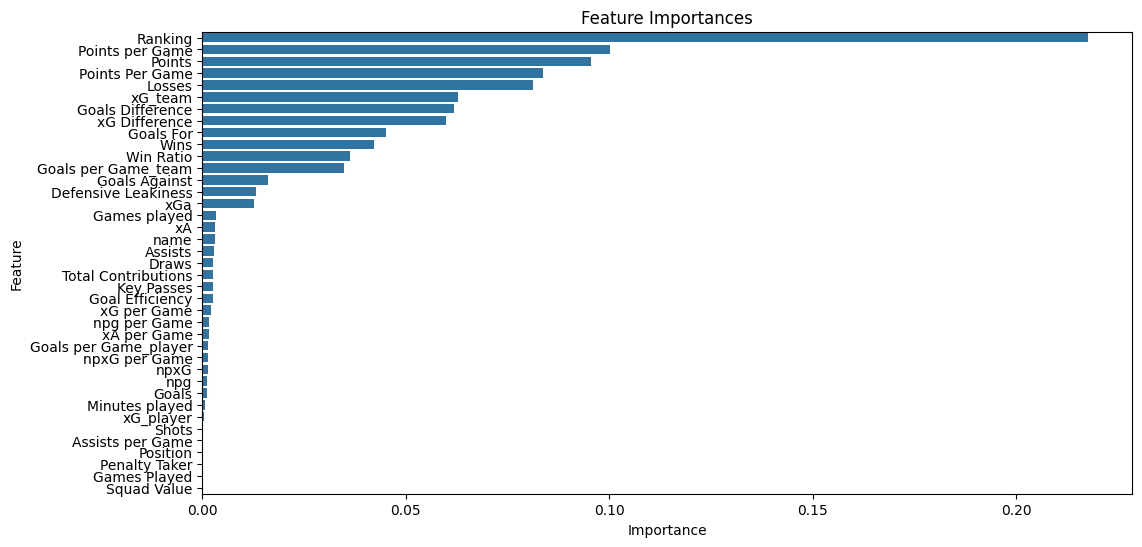

In [59]:
#Let's evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
# We can also visualize the feature importances
feature_importances = rf_classifier.feature_importances_
feature_names = X.columns
# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Plot the feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#6 Simulate Next Season

#7 Visualizations